In [ ]:
!pip install pandas numpy matplotlib
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00


In [ ]:
import os, zipfile, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile, tarfile, os

zip_path = '/content/drive/MyDrive/BIDS_STATS.zip'  # adjust if needed
out_dir  = '/content/BIDS_STATS'

if not os.path.exists(out_dir):
    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall('/content')
        print("✅ Extracted as ZIP")
    except zipfile.BadZipFile:
        print("⚠️ BadZipFile, trying tarfile …")
        with tarfile.open(zip_path, 'r:*') as t:
            t.extractall('/content')
        print("✅ Extracted via tarfile")

print("Found", len(os.listdir(out_dir)), "files in", out_dir)


⚠️ BadZipFile, trying tarfile …
✅ Extracted via tarfile
Found 58 files in /content/BIDS_STATS


In [ ]:
def read_aparc_stats(path):
    cols = ['StructName','NumVert','SurfArea','GrayVol','ThickAvg','ThickStd',
            'MeanCurv','GausCurv','FoldInd','CurvInd']
    rows = []
    with open(path) as f:
        for line in f:
            if line.startswith('#'): continue
            parts = line.strip().split()
            if len(parts)>=10:
                rows.append(parts[:10])
    df = pd.DataFrame(rows, columns=cols).set_index('StructName').astype(float)
    return df[['SurfArea','GrayVol','ThickAvg','ThickStd',
               'MeanCurv','GausCurv','FoldInd','CurvInd']]

In [ ]:
stats_dir = '/content/BIDS_STATS'
msn_dir   = '/content/MSN_outputs'
os.makedirs(msn_dir, exist_ok=True)

# get subject IDs from left‐hemi files
lh_files = glob.glob(f"{stats_dir}/*_lh.aparc.stats")
subjects = sorted([os.path.basename(f).split('_processed_lh')[0] for f in lh_files])

for subj in subjects:
    lh = read_aparc_stats(f"{stats_dir}/{subj}_processed_lh.aparc.stats")
    rh = read_aparc_stats(f"{stats_dir}/{subj}_processed_rh.aparc.stats")
    df = pd.concat([lh, rh], axis=0)
    dfz = (df - df.mean())/df.std()
    msn = dfz.T.corr().values
    np.save(f"{msn_dir}/{subj}_MSN.npy", msn)
    pd.Series(dfz.index, name='Region') \
      .to_csv(f"{msn_dir}/{subj}_regions.csv", index=False)
    print(f"{subj}: saved MSN {msn.shape}")

sub-0028197: saved MSN (68, 68)
sub-0028198: saved MSN (68, 68)
sub-0028199: saved MSN (68, 68)
sub-0028200: saved MSN (68, 68)
sub-0028201: saved MSN (68, 68)
sub-0028202: saved MSN (68, 68)
sub-0028203: saved MSN (68, 68)
sub-0028204: saved MSN (68, 68)
sub-0028205: saved MSN (68, 68)
sub-0028206: saved MSN (68, 68)
sub-0028207: saved MSN (68, 68)
sub-0028208: saved MSN (68, 68)
sub-0028209: saved MSN (68, 68)
sub-0028210: saved MSN (68, 68)
sub-0028211: saved MSN (68, 68)
sub-0028212: saved MSN (68, 68)
sub-0028213: saved MSN (68, 68)
sub-0028214: saved MSN (68, 68)
sub-0028215: saved MSN (68, 68)
sub-0028216: saved MSN (68, 68)
sub-0028217: saved MSN (68, 68)
sub-0028218: saved MSN (68, 68)
sub-0028219: saved MSN (68, 68)
sub-0028220: saved MSN (68, 68)
sub-0028221: saved MSN (68, 68)
sub-0028222: saved MSN (68, 68)
sub-0028223: saved MSN (68, 68)
sub-0028224: saved MSN (68, 68)
sub-0028225: saved MSN (68, 68)


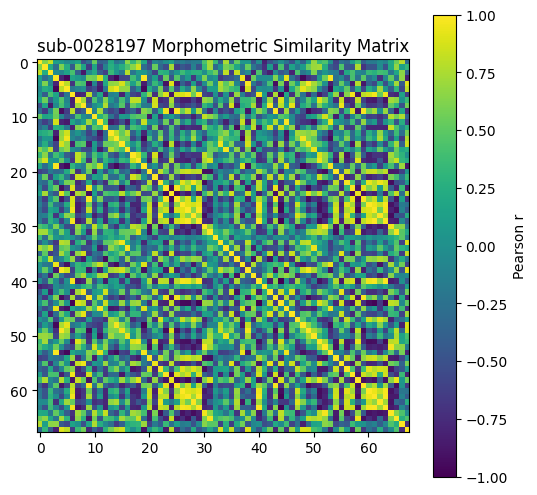

In [ ]:
m = np.load(f"{msn_dir}/{subjects[0]}_MSN.npy")
plt.figure(figsize=(6,6))
plt.imshow(m, vmin=-1, vmax=1, aspect='equal')
plt.colorbar(label='Pearson r')
plt.title(f'{subjects[0]} Morphometric Similarity Matrix')
plt.show()

In [ ]:
dropdown = widgets.Dropdown(
    options=subjects,
    description='Subject:',
    style={'description_width':'initial'},
    layout=widgets.Layout(width='50%')
)
output = widgets.Output()

def on_change(change):
    if change['name']=='value':
        subj = change['new']
        m = np.load(f"{msn_dir}/{subj}_MSN.npy")
        with output:
            clear_output(wait=True)
            plt.figure(figsize=(6,6))
            plt.imshow(m, vmin=-1, vmax=1, aspect='equal')
            plt.colorbar(label='Pearson r')
            plt.title(f'{subj} MSN')
            plt.show()

dropdown.observe(on_change, names='value')
display(dropdown, output)

# initial display
on_change({'name':'value','new':subjects[0]})

Dropdown(description='Subject:', layout=Layout(width='50%'), options=('sub-0028197', 'sub-0028198', 'sub-00281…

Output()

In [ ]:
# K-means clustering on the upper triangle of every MSN
import glob, os, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

MSN_DIR = '/content/MSN_outputs'
msn_files = sorted(glob.glob(os.path.join(MSN_DIR, '*_MSN.npy')))
msns = np.stack([np.load(f) for f in msn_files], axis=0)  # shape (29, R, R)

# extract upper triangle
n_subj, n_reg, _ = msns.shape
triu = np.triu_indices(n_reg, k=1)
X = np.stack([m[triu] for m in msns], axis=0)

# standardize
X_scaled = StandardScaler().fit_transform(X)

# k-means
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_scaled)
labels = kmeans.labels_
sil = silhouette_score(X_scaled, labels)

print("Labels:", labels)
print("Silhouette:", sil)

# sweep over k to find the best number of clusters
best_k, best_sil = None, -1
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    s = silhouette_score(X_scaled, km.labels_)
    print(f"k={k:>2} → silhouette={s:.3f}")
    if s > best_sil:
        best_sil, best_k = s, k

print(f"\n>> Best k = {best_k} (silhouette = {best_sil:.3f})")


Labels: [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
Silhouette: 0.10536934916744609
k= 2 → silhouette=0.105
k= 3 → silhouette=0.015
k= 4 → silhouette=0.019
k= 5 → silhouette=0.003

>> Best k = 2 (silhouette = 0.105)


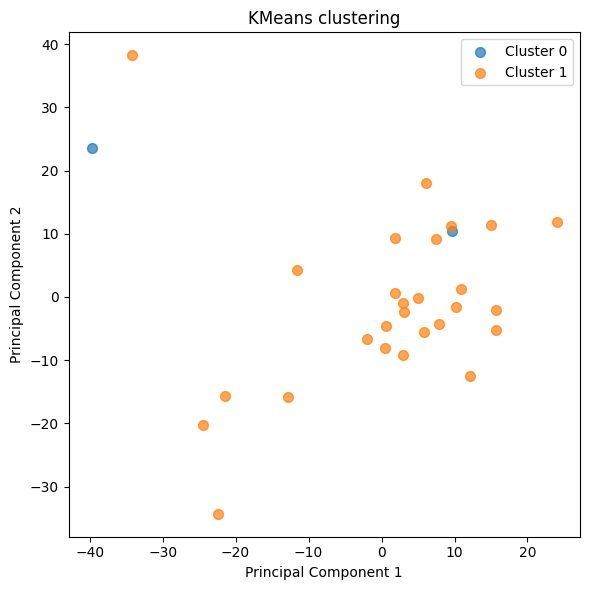

In [ ]:
# PCA scatter of KMeans (k=2) clusters
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans

# re-fit KMeans (k=2)
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_scaled)
labels = kmeans.labels_

# PCA down to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# plot clusters
plt.figure(figsize=(6,6))
for lab in np.unique(labels):
    pts = X_pca[labels == lab]
    plt.scatter(pts[:,0], pts[:,1], label=f'Cluster {lab}', s=50, alpha=0.7)

plt.title('KMeans clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.show()
